## Capstone - Final Submission

<h2>Table of contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
    <li><a href="#Introduction">Introduction</a>
    </li>
    <li><a href="#Data">Data</a></li>
    <li><a href="#Methodology">Methodology</a></li>
    <li><a href="#Conclusions">Conclusions</a></li>
</ul>

## Introduction

### Business Problem Definition

My husband and I have lived in Vancouver for the past 5 years. I work for a startup company and he works for the city of Port Coquitlam as an arborist.  We have recently had a son and would like to consider moving to an area in BC that is more affordable where our son would be able to interact with nature more frequently on our property.  

We are also extremely interested in starting up a business with friends to run an organic farm and set up a brewery.  Our friends have 2 years experience running their own organic plot on an acre of land and a number of years working for the UBC farm prior to that. Collectively we have 0 experience in brewing but we have some great business experience to rely on and are all hard workers. The issue is, determining the location to live in to set up these businesses is extremely critical and could be the difference between success and failure. We would need land that is appropriate for farming, and ideally would give us access to a long growing season.  As for a brewery, off the top of my head we would need a population that would support it AND we would not want to be competing with other breweries in the area. Most practically, we need to be able to afford purchasing a piece of land that would support these endeavers. Lastly, lifestyle is extremely important to us and we would like to have access to many outdoor activities but most importantly excellent hiking trails.

It would be very helpful to get a list of cities where a farming/brewery business would be opportunistic alongside reasonable realestate prices.  

# Data

## Data Required

I'd like to filter down the a list of 3-5 cities for consideration based on the following:
1. Housing costs
2. Population size
3. Proximity to trails (important lifestyle attribute for us)
4. Number of breweries, farms and if they have a farmers market in the city (All these are searchable 'Venue Categories' in Foursquare based on https://developer.foursquare.com/docs/build-with-foursquare/categories/)

Ideally will analyze the above and choose top cities by a combination of:
1. Minimizing breweries & farms per population
2. Proximity to farmers markets from city center 
3. Proximity to trails from city center
4. Minimizing Housing costs

## Data Sources

In order to solve this problem I will need 3 main datasets
1. Housing prices in BC
2. Population sizes in BC
3. Foursquare info on Venue Categories in each city

For Housing prices:
 - Statistics Canada: https://www150.statcan.gc.ca/n1/en/subjects/housing/housing_costs_and_affordability

For Population sizes:
 - Gov BC Website: https://www2.gov.bc.ca/gov/content/data/statistics/people-population-community/population/population-estimates

Growing Season Length:
 - Range of last days of frost in BC cities : https://www.plantmaps.com/interactive-british-columbia-last-frost-date-map.php
 - Range of first days of frost in BC cities : https://www.plantmaps.com/interactive-british-columbia-first-frost-date-map.php

## Data Analysis

#### Import Libraries

In [1]:
#Import Libraries
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # library for data analsysis
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Maps
import folium # map rendering library

#Geocoder for pulling lat/long
import geocoder

#Used if I want to scrape any websites for data
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs

#used for cluster visualization
from mpl_toolkits.mplot3d import Axes3D 

## Housing Affordability Data

### Cleaning the dataset from Statistics Canada

In [2]:
# Downloaded excel file from Statistics Canada Site: 
# https://www150.statcan.gc.ca/n1/en/subjects/housing/housing_costs_and_affordability
df=pd.read_excel('Housing_Export.xlsx', sheet_name='Data')

In [3]:
# Storing data in dataframe
df=pd.DataFrame(df)

In [4]:
#Understanding Size, Columns and Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813 entries, 0 to 812
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DGUID               813 non-null    object
 1   Location            813 non-null    object
 2   Province/Territory  813 non-null    object
 3   Value               813 non-null    object
 4   Data Comment        3 non-null      object
dtypes: object(5)
memory usage: 31.9+ KB


In [5]:
df.head(10)

,DGUID,Location,Province/Territory,Value,Data Comment
0,2016A00055947007,"Port Edward, DM",British Columbia,x,Suppressed to meet the confidentiality require...
1,2016A00055949020,"Kitimat-Stikine C (Part 2), RDA",British Columbia,x,Suppressed to meet the confidentiality require...
2,2016A00055953050,"Fraser-Fort George G, RDA",British Columbia,x,Suppressed to meet the confidentiality require...
3,2016A00055905052,"Kootenay Boundary D / Rural Grand Forks, RDA",British Columbia,$100,NaN
4,2016A00055949028,"Kitimat-Stikine B, RDA",British Columbia,$400,NaN
5,2016A00055951017,"Bulkley-Nechako D, RDA",British Columbia,$900,NaN
6,2016A00055951019,"Bulkley-Nechako F, RDA",British Columbia,"$3,200",NaN
7,2016A00053554066,"Gauthier, TP",Ontario,"$9,800",NaN
8,2016A00053554056,"Matachewan, TP",Ontario,"$10,000",NaN
9,2016A00055947016,"Skeena-Queen Charlotte A, RDA",British Columbia,"$12,200",NaN


In [6]:
# Creating new dataframe 'cityname' that is aimed at cleaning the city data contained in the "Location" column
# We will need to pass this data through geocoder to get latitude and longitude coordinates so this is a critical
# step in order to make that city readable for that function
cityname=df.Location.str.split(',', expand=True)
#Name Columns
cityname.columns = ['City','One','Two','Three']
cityname=cityname.City.str.split(' ', expand=True)
cityname.columns=['City','two','three','four','five','six','seven']

In [7]:
cityname.head()

,City,two,three,four,five,six,seven
0,Port,Edward,None,None,None,None,None
1,Kitimat-Stikine,C,(Part,2),None,None,None
2,Fraser-Fort,George,G,None,None,None,None
3,Kootenay,Boundary,D,/,Rural,Grand,Forks
4,Kitimat-Stikine,B,None,None,None,None,None


In [8]:
city_copy=cityname #create copy so I have original cityname_clean untouched from here on out

In [9]:
# This section will take city_copy and concatenate 'City' column with 'two' when there is a string value greater
# than 1 in column two (this means it is not just an uneccessary initial like a lot of them have)

#delete all null values in dataframe and replace with N
city_copy=city_copy.fillna('N')

# loop that scans column 'two' to determine if there is a name there - if so, concatenate column one
# with column two to get the full city name in one cell
for i in range (0,len(city_copy)):
    if len(city_copy.two[i])>1:
        city_copy.City[i]=city_copy.City[i]+' '+ city_copy.two[i]

In [10]:
#copy Reformatted cityname to main dataframe, df and save as "Location"
df['Location']=city_copy['City']

In [11]:
#Rename Columns of Original Dataframe
df.rename(columns={'Province/Territory':'Prov_Ter'}, inplace=True)
df.drop(columns=['DGUID','Data Comment'], inplace=True)

In [12]:
df.head()

,Location,Prov_Ter,Value
0,Port Edward,British Columbia,x
1,Kitimat-Stikine,British Columbia,x
2,Fraser-Fort George,British Columbia,x
3,Kootenay Boundary,British Columbia,$100
4,Kitimat-Stikine,British Columbia,$400


In [13]:
#Look to see which provinces were included in the data from stats Canada, I'm only interested in those from BC
df.groupby('Prov_Ter').count()

,Location,Value
Prov_Ter,,
British Columbia,319,319
Nova Scotia,70,70
Ontario,424,424


In [14]:
# Delete Ontario and Nova Scotia Entries
indexNames = df[ df['Prov_Ter'] == 'Ontario' ].index
df.drop(indexNames , inplace=True)
indexNames = df[ df['Prov_Ter'] == 'Nova Scotia' ].index
df.drop(indexNames , inplace=True)

In [15]:
# Delete rows with no housing pricing info
indexNames = df[ df['Value'] == 'x' ].index
df.drop(indexNames , inplace=True)

In [16]:
# Reset index after I deleted a large portion of the dataset and drop the old index column
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)

In [17]:
df

,Location,Prov_Ter,Value
0,Kootenay Boundary,British Columbia,$100
1,Kitimat-Stikine,British Columbia,$400
2,Bulkley-Nechako,British Columbia,$900
3,Bulkley-Nechako,British Columbia,"$3,200"
4,Skeena-Queen Charlotte,British Columbia,"$12,200"
...,...,...,...
311,North Vancouver,British Columbia,"$1,490,000"
312,Lions Bay,British Columbia,"$1,550,000"
313,Belcarra,British Columbia,"$1,790,000"
314,Anmore,British Columbia,"$1,960,000"


### Clean out duplicates of cities/regions

In [18]:
#determine the number of duplicate cities/regions
#for all duplicates I should take the average home value and set that as the value for the region
duplicate_df=df.groupby('Location').count() #note after this command there are only 184 rows. this means there are many duplicates
print("number of duplicate entries in 'Location' is ", df.shape[0]-duplicate_df.shape[0])

number of duplicate entries in 'Location' is  132


In [19]:
#create list (dup) of all areas with duplications
dup=[]
for i in range(0,len(duplicate_df)):
    if duplicate_df.Prov_Ter[i] >1:
        dup.append(duplicate_df.index[i])
print('done') 

done


### Calculate median of housing values for duplicate entries in 'Location'

In [20]:
#First need to convert currency information contained in 'Value' to integer so I perform a calculation
Values=df['Value'].replace({'\$': '', ',': ''}, regex=True).astype(int)
df['Value']=Values
df.dtypes

Location    object
Prov_Ter    object
Value        int64
dtype: object

In [21]:
#creates tuple,c, that stores all data for duplicate regions in df
#creates list, d, that stores all median housing values for each region 

###test with one off: a=df[df['Location'].str.match(dup[1])]

c=[]
d=[]
for i in range(0,len(dup)):
    c.append(df[df['Location'].str.match(dup[i])])
    d.append(c[i].Value.median())
print(len(dup),'should equal:',len(d))  # checks to see if list containing median housing values per duplicate region 
                                        # is the same length as the original list of duplicate region names

29 should equal: 29


In [22]:
#saves duplicate city names and median housing prices for that region in a dataframe called MR
mreg=[dup,d]
MR=pd.DataFrame(np.transpose(mreg))
MR.head()

,0,1
0,Alberni-Clayoquot,273500.0
1,Bulkley-Nechako,92800.0
2,Cariboo,145000.0
3,Central Coast,71800.0
4,Central Kootenay,206000.0


In [23]:
# Double check that the number of city names in our region duplicate list (dup) 
# has a match in the original dataframe column df.Location
mask=df.Location.isin(dup)
sum(mask) #provides number of duplicates in df
len(df)-sum(mask)+len(dup) #should equal len(df.groupby('Location').count()) #it does so we are doing the right thing

184

In [24]:
#drop duplicates of regions
# sorting by first name 
df.sort_values("Location", inplace = True) 
###CAUTION
# dropping ALL duplicte values (will need to re-add median values to represent those regions)
df.drop_duplicates(subset ="Location", 
                     keep = False, inplace = True)

In [25]:
# checking shape of dataframe. It should equal the original length (184)
# minus the length of the duplicate region list (29) = 155
df.shape

(155, 3)

In [26]:
# This means I simply need to concatenate MR dataframe with df to get full list with median values 
# adjusted for regions with duplicates I assume it didnt keep any records because of the keep=false 
# clause in the drop_duplicate line of code

MR.columns=['Location','Value']
Prov=['British Columbia']*29
MR['Prov_Ter']=Prov
df_attempt = pd.concat([MR, df])
df=df_attempt
df.sort_values("Location", inplace = True) 
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df.head(15)
print('data frame length should equal original of 184. Check: ', df.shape)

data frame length should equal original of 184. Check:  (184, 3)


### Ran geocoder first and then found the cities that were not legitimate

In [27]:
# issues with specific cities
#df.loc[19,:] #Cityname wasn't a city
#df.loc[102,:] #Cityname wasn't a city
#df.loc[109,:] #Cityname wasn't a city

In [28]:
#drop index's which didn't have legit city name
df.drop([19],inplace=True)
df.drop([102],inplace=True)
df.drop([109],inplace=True)

In [29]:
#df.drop(columns=['level_0','index'],inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)

In [30]:
#new shape after dropping illegitamate city names
df.shape

(181, 3)

### Generate Lat/Long coordinates for each city/region

In [31]:
# This Section was tough because the geocoder kept timing out on me, so what I did was ran it many times
# and stored the latitude and longitude variables in 50 length chunks until I got to through the entire
# dataframe df.Location

# I've included the code that I used to get here - and then I exported the values to a csv file that I will call
# in this notebook so I know it will run properly for you

# *************************** ORIGINAL CODE UTILIZED TO GET LAT/LONG COORDS for dataframe df**********************#
#
#
# latitude=[]
# longitude=[]
# geolocator = Nominatim(user_agent="bc_explorer")
# lat_lng_coords=[]
# # loop until you get the coordinates
# for i in range(100,150):
#     print(i)
#     location = geolocator.geocode('{}, {}'.format(df.Location[i],df.Prov_Ter[i]))
#     latitude.append(location.latitude)
#     longitude.append(location.longitude)
# else:
#     print('none')
# print('done')
#
#
# geocoder service times out a lot so completed code in chunks of 50 
#
# latitude_50=latitude
# longitude_50=longitude
# print(len(latitude_50))
# print(len(longitude_50))

# latitude_100=latitude_50+latitude
# longitude_100=longitude_50+longitude
# print(len(latitude_100))
# print(len(longitude_100))

# latitude_150=latitude_100+latitude
# longitude_150=longitude_100+longitude
# print(len(latitude_150))
# print(len(longitude_150))

# latitude_181=latitude_150+latitude
# longitude_181=longitude_150+longitude
# print(len(latitude_181))
# print(len(longitude_181))

# # This was used to store latitude and longitudes generated into their own dataframe and export it to .csv
# lat_long=[latitude_181,longitude_181]
# lat_long=pd.DataFrame(lat_long).transpose()
# lat_long.columns=['Latitude','Longitude']
#
# # export Lat/Long coordinates to csv file
# lat_long.to_csv('lat_long.csv')

In [32]:
# load csv created in last step
lat_long=pd.read_csv('lat_long.csv')
lat_long=pd.DataFrame(lat_long)
lat_long.head()

,Unnamed: 0,Latitude,Longitude
0,0,49.052116,-122.329479
1,1,49.266667,-124.800000
2,2,50.583333,-126.916667
3,3,49.314443,-122.856460
4,4,50.443575,-119.194406


In [33]:
#Add Lat/Long coordinates to dataframe df
df['Latitude']=lat_long['Latitude']
df['Longitude']=lat_long['Longitude']

In [34]:
print('shape should remain the same as original with a length of 181 and 2 added columns. Check: ', df.shape)

shape should remain the same as original with a length of 181 and 2 added columns. Check:  (181, 5)


In [35]:
df.head()

,Location,Value,Prov_Ter,Latitude,Longitude
0,Abbotsford,620000,British Columbia,49.052116,-122.329479
1,Alberni-Clayoquot,273500.0,British Columbia,49.266667,-124.800000
2,Alert Bay,104000,British Columbia,50.583333,-126.916667
3,Anmore,1960000,British Columbia,49.314443,-122.856460
4,Armstrong,337000,British Columbia,50.443575,-119.194406


## City Population Size

In [36]:
# I downloaded an xlsx file from the Government of BC website:
# https://www2.gov.bc.ca/gov/content/data/statistics/people-population-community/population/population-estimates
# store in two dataframes for two different sheets in xlsx file; pop_1 and pop_2, 

pop_1=pd.read_excel('pop_bc.xlsx', sheet_name='Mun-RD')
pop_2=pd.read_excel('pop_bc.xlsx', sheet_name='Dev-Mun')

In [37]:
# Start cleaning dataset
pop_1.drop([0],inplace=True)
pop_1.columns=pop_1.loc[1,:]
pop_1.drop([1],inplace=True)
pop_1.head()

1,SGC,Name,Area Type,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,...,2019.0,NaN,2011-12 Changes,2012-13 Changes,2013-14 Changes,2014-15 Changes,2015-16 Changes,2016-17 Changes,2017-18 Changes,2018-19 Changes
2,23000,Alberni-Clayoquot,RD,31623.0,31444.0,31335.0,31503.0,31743.0,32287.0,32572.0,...,33315.0,NaN,-0.00566044,-0.00346648,0.00536142,0.00761832,0.0171376,0.00882708,0.0116665,0.011016
3,23008,Port Alberni,CY,18026.0,17928.0,17766.0,17753.0,18012.0,18360.0,18465.0,...,18751.0,NaN,-0.00543659,-0.00903614,-0.000731735,0.0145891,0.0193205,0.00571895,0.0115895,0.0038546
4,23025,Tofino,DM,1952.0,1977.0,1981.0,2050.0,2068.0,2082.0,2187.0,...,2434.0,NaN,0.0128074,0.00202327,0.0348309,0.00878049,0.00676983,0.0504323,0.038866,0.0713028
5,23019,Ucluelet,DM,1676.0,1645.0,1701.0,1653.0,1706.0,1812.0,1896.0,...,1842.0,NaN,-0.0184964,0.0340426,-0.0282187,0.0320629,0.0621336,0.0463576,-0.0337553,0.00545852
6,23999,Unincorporated Areas,RDR,9969.0,9894.0,9887.0,10047.0,9957.0,10033.0,10024.0,...,10288.0,NaN,-0.00752332,-0.000707499,0.0161829,-0.0089579,0.00763282,-0.00089704,0.0144653,0.0117022


In [38]:
#drop null columns so coluns will match with pop_2 when I join them together
pop_1.columns = pop_1.columns.fillna('to_drop')
pop_1.drop('to_drop', axis = 1, inplace = True)

In [39]:
#Rename Name to 'Location'
pop_1.rename(columns={'Name':'Location'}, 
                 inplace=True)

In [40]:
pop_1.head()

1,SGC,Location,Area Type,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2011-12 Changes,2012-13 Changes,2013-14 Changes,2014-15 Changes,2015-16 Changes,2016-17 Changes,2017-18 Changes,2018-19 Changes
2,23000,Alberni-Clayoquot,RD,31623.0,31444.0,31335.0,31503.0,31743.0,32287.0,32572.0,32952.0,33315.0,-0.00566044,-0.00346648,0.00536142,0.00761832,0.0171376,0.00882708,0.0116665,0.011016
3,23008,Port Alberni,CY,18026.0,17928.0,17766.0,17753.0,18012.0,18360.0,18465.0,18679.0,18751.0,-0.00543659,-0.00903614,-0.000731735,0.0145891,0.0193205,0.00571895,0.0115895,0.0038546
4,23025,Tofino,DM,1952.0,1977.0,1981.0,2050.0,2068.0,2082.0,2187.0,2272.0,2434.0,0.0128074,0.00202327,0.0348309,0.00878049,0.00676983,0.0504323,0.038866,0.0713028
5,23019,Ucluelet,DM,1676.0,1645.0,1701.0,1653.0,1706.0,1812.0,1896.0,1832.0,1842.0,-0.0184964,0.0340426,-0.0282187,0.0320629,0.0621336,0.0463576,-0.0337553,0.00545852
6,23999,Unincorporated Areas,RDR,9969.0,9894.0,9887.0,10047.0,9957.0,10033.0,10024.0,10169.0,10288.0,-0.00752332,-0.000707499,0.0161829,-0.0089579,0.00763282,-0.00089704,0.0144653,0.0117022


In [41]:
# dropping null value columns to avoid errors 
pop_1.dropna(subset=['Location'],inplace=True)

In [42]:
#Sort List based on City Names
pop_1.sort_values("Location", inplace = True) 

In [43]:
#store cleaned dataframe with duplicates removed
cleaned_pop1=pop_1.drop_duplicates(subset ="Location", keep = 'first')

In [44]:
#reset index
cleaned_pop1.reset_index(inplace=True)
cleaned_pop1.drop(columns=['index'],inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [45]:
cleaned_pop1.shape

(193, 20)

In [46]:
## Found issue - preceding spaces are messing with my merge!
#method to strip spaces in strings is: data['values'].str.strip()
cleaned_pop1['Location']=cleaned_pop1['Location'].str.strip()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Join other population tables together before merging with housing price data

In [47]:
pop_2=pd.read_excel('pop_bc.xlsx', sheet_name='Dev-Mun')

In [48]:
pop_1.shape

(219, 20)

In [49]:
pop_2.columns=pop_1.columns

In [50]:
pop_2.head()

1,SGC,Location,Area Type,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2011-12 Changes,2012-13 Changes,2013-14 Changes,2014-15 Changes,2015-16 Changes,2016-17 Changes,2017-18 Changes,2018-19 Changes
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,Area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
2,SGC,Name,Type,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,Changes,Changes,Changes,Changes,Changes,Changes,Changes,Changes
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Vancouver Island/Coast,NaN,773313.0,782560.0,792069.0,803040.0,815175.0,832141.0,844988.0,857791.0,870297.0,0.0119576,0.0121511,0.0138511,0.0151113,0.0208127,0.0154385,0.0151517,0.0145793


In [51]:
# dropping null value columns to avoid errors 
pop_2.dropna(subset=['Location'],inplace=True)

In [52]:
#store cleaned dataframe with duplicates removed
cleaned_pop2=pop_2.drop_duplicates(subset ="Location", 
                     keep = 'first')

In [53]:
cleaned_pop2.shape

(173, 20)

In [54]:
## Found issue - preceding spaces are messing with my merge!
#method to strip spaces in strings is: data['values'].str.strip()
cleaned_pop2['Location']=cleaned_pop2['Location'].str.strip()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
#pop_merg=pd.merge(cleaned_pop1, cleaned_pop2, on='Location', how='inner')
pop_merg = pd.concat([cleaned_pop1, cleaned_pop2], ignore_index=True)

In [56]:
pop_merg_copy=pop_merg

In [57]:
pop_merg=pop_merg.drop_duplicates(subset ="Location", keep = 'first') #remove duplicates from merged list
pop_merg.reset_index(inplace=True) #reset index
pop_merg.drop(columns=['index'],inplace=True) #drop old index

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
pop_merg.shape

(198, 20)

In [59]:
pop_merg

1,SGC,Location,Area Type,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2011-12 Changes,2012-13 Changes,2013-14 Changes,2014-15 Changes,2015-16 Changes,2016-17 Changes,2017-18 Changes,2018-19 Changes
0,9052,Abbotsford,CY,136793.0,138266.0,140156.0,141658.0,144373.0,148056.0,151313.0,155507.0,158457.0,0.0107681,0.0136693,0.0107166,0.0191659,0.0255103,0.0219984,0.0277174,0.0189702
1,43008,Alert Bay,VL,441.0,452.0,464.0,478.0,482.0,492.0,465.0,443.0,473.0,0.0249433,0.0265487,0.0301724,0.0083682,0.0207469,-0.054878,-0.0473118,0.0677201
2,15038,Anmore,VL,2143.0,2220.0,2249.0,2298.0,2299.0,2316.0,2438.0,2436.0,2515.0,0.0359309,0.0130631,0.0217875,0.000435161,0.00739452,0.052677,-0.000820345,0.0324302
3,37028,Armstrong,CY,4906.0,4961.0,5003.0,5098.0,5183.0,5300.0,5240.0,5426.0,5499.0,0.0112108,0.00846604,0.0189886,0.0166732,0.0225738,-0.0113208,0.0354962,0.0134537
4,33019,Ashcroft,VL,1645.0,1580.0,1661.0,1622.0,1544.0,1603.0,1680.0,1600.0,1575.0,-0.0395137,0.0512658,-0.0234798,-0.0480888,0.0382124,0.0480349,-0.047619,-0.015625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,NaN,Mainland/Southwest,NaN,2727081.0,2776497.0,2821387.0,2875004.0,2919153.0,2968131.0,3007280.0,3055208.0,3101043.0,0.0181205,0.0161679,0.0190038,0.0153562,0.0167782,0.0131898,0.0159373,0.0150023
194,NaN,Thompson/Okanagan,NaN,530028.0,533259.0,538667.0,546577.0,556207.0,568912.0,578974.0,590541.0,599073.0,0.0060959,0.0101414,0.0146844,0.0176187,0.0228422,0.0176864,0.0199784,0.0144478
195,NaN,Kootenay,NaN,148621.0,149620.0,150771.0,152511.0,154709.0,157119.0,158384.0,160156.0,161438.0,0.0067218,0.00769282,0.0115407,0.0144121,0.0155776,0.00805122,0.011188,0.0080047
196,NaN,Nechako,NaN,40569.0,40433.0,40351.0,40382.0,40122.0,40241.0,40185.0,40252.0,40348.0,-0.00335231,-0.00202805,0.000768259,-0.00643851,0.00296595,-0.00139162,0.00166729,0.00238497


## Growing Season Length

In [60]:
#Scrape Table from Website using Pandas, Average last day of frost
grow = pd.read_html('https://www.plantmaps.com/interactive-british-columbia-last-frost-date-map.php')
grow=grow[3]

In [61]:
grow.head()

,Location,Average Last Frost Date
0,100 Mile House,Jun. 1 - Jun. 10
1,Abbotsford,Apr. 1 - Apr. 10
2,Agassiz,Mar. 21 - Mar. 31
3,Aiyansh,May 1 - May 10
4,Alexandria,May 21 - May 31


In [62]:
#To be conservative I will assume that the last date in the date range is the LAST frost date
# this means I need to split the "Average Last Frost Date" Column and only consider the last date
lastfrost=grow['Average Last Frost Date'].str.split('-', expand=True)
lastfrost.columns = ['Opt','Last'] #Rename Columns
last_F=lastfrost.Last.str.replace('.','') #Remove period in month string replace
grow['Last']=last_F #Add reformatted conservative last frost date to grow df
grow['Last']=grow['Last'].str.strip()

In [63]:
grow.head()

,Location,Average Last Frost Date,Last
0,100 Mile House,Jun. 1 - Jun. 10,Jun 10
1,Abbotsford,Apr. 1 - Apr. 10,Apr 10
2,Agassiz,Mar. 21 - Mar. 31,Mar 31
3,Aiyansh,May 1 - May 10,May 10
4,Alexandria,May 21 - May 31,May 31


Do another scrub of this website in order to get the conservative FIRST day of frost in the year
https://www.plantmaps.com/interactive-british-columbia-first-frost-date-map.php

In [64]:
#Scrape Table from Website using Pandas
grow2=pd.read_html('https://www.plantmaps.com/interactive-british-columbia-first-frost-date-map.php')

In [65]:
grow2=grow2[3] #set grow2 dataframe equal to the third table contained in grow2 from web scrape

In [66]:
grow2.head()

,Location,Average First Frost Date
0,100 Mile House,Sep. 1 - Sep. 10
1,Abbotsford,Nov. 1 - Nov. 10
2,Agassiz,Nov. 11 - Nov. 20
3,Aiyansh,Sep. 21 - Sep. 30
4,Alexandria,Sep. 11 - Sep. 20


In [67]:
#To be conservative I will assume that the first date in the date range is the FIRST frost date
# this means I need to split the "Average First Frost Date" Column and only consider the first date
firstfrost=grow2['Average First Frost Date'].str.split('-', expand=True)
firstfrost.columns = ['Opt','First'] #Rename Columns
first_F=firstfrost.First.str.replace('.','') #Remove period in month string replace
grow['First']=first_F #Add reformatted conservative first frost date to grow df

In [68]:
grow['First']=grow['First'].str.strip()

In [69]:
#****I thought issue I was having was due to leap year feb 29 not being valid with year 1900 but in general that
# date does not do well with those functions.

#So instead replace values of Feb 29 with Feb 28
grow['Last']=grow.Last.str.replace('Feb 29','Feb 28')

### Now, DAYS WITHOUT FROST would equal the FIRST day of frost minus the LAST day of frost, and we need that in days

In [70]:
grow=grow.dropna(subset=['First','Last']) #drop rows with null/na/NaN values in First or Last Dates

In [71]:
grow.reset_index(inplace=True) #reset index
grow.drop(columns=['index'],inplace=True)

In [72]:
#Convert string dates to dates recognized in dataframe
grow['Last_date'] = pd.to_datetime(grow['Last'], format='%b %d')
grow['First_date'] = pd.to_datetime(grow['First'], format='%b %d')

In [73]:
grow.head()

,Location,Average Last Frost Date,Last,First,Last_date,First_date
0,100 Mile House,Jun. 1 - Jun. 10,Jun 10,Sep 10,1900-06-10,1900-09-10
1,Abbotsford,Apr. 1 - Apr. 10,Apr 10,Nov 10,1900-04-10,1900-11-10
2,Agassiz,Mar. 21 - Mar. 31,Mar 31,Nov 20,1900-03-31,1900-11-20
3,Aiyansh,May 1 - May 10,May 10,Sep 30,1900-05-10,1900-09-30
4,Alexandria,May 21 - May 31,May 31,Sep 20,1900-05-31,1900-09-20


In [74]:
##### Now subtract LAST frost date from FIRST frost date to get growing season length in days. Save to grow df
grow['Growing_Days']=(grow.First_date-grow.Last_date).dt.days

In [75]:
grow

,Location,Average Last Frost Date,Last,First,Last_date,First_date,Growing_Days
0,100 Mile House,Jun. 1 - Jun. 10,Jun 10,Sep 10,1900-06-10,1900-09-10,92
1,Abbotsford,Apr. 1 - Apr. 10,Apr 10,Nov 10,1900-04-10,1900-11-10,214
2,Agassiz,Mar. 21 - Mar. 31,Mar 31,Nov 20,1900-03-31,1900-11-20,234
3,Aiyansh,May 1 - May 10,May 10,Sep 30,1900-05-10,1900-09-30,143
4,Alexandria,May 21 - May 31,May 31,Sep 20,1900-05-31,1900-09-20,112
...,...,...,...,...,...,...,...
306,Williams Lake,May 21 - May 31,May 31,Sep 20,1900-05-31,1900-09-20,112
307,Wistaria,May 11 - May 20,May 20,Sep 10,1900-05-20,1900-09-10,113
308,Woodcock,May 11 - May 20,May 20,Oct 10,1900-05-20,1900-10-10,143
309,Woodpecker,May 21 - May 31,May 31,Sep 20,1900-05-31,1900-09-20,112


## Merging population dataset, housing price dataset, and growing season dataset

In [76]:
#Merged population dataset that I'll be working from: pop_merge
#Housing price dataset that I'll be working from: df
#Growing season dataset that I'll be working from: grow

#******** PERFORM MERGE 1 ***************#
#
df_merged = pd.merge(df, pop_merg[['Location',2019.0,'2018-19 Changes']], on='Location')
#
#******** PERFORM MERGE 2 ***************#
full_merge = pd.merge(df_merged, grow[['Location','Last_date','First_date','Growing_Days']], on='Location')
#

There was a loss of information associated with merging datasets. The first loss of information was going from 198 datapoints for population sizes to 166 datapoints with population sizes AND housing prices to 108 datapoints with population sizes, housing prices AND growing season info.

In [77]:
full_merge

,Location,Value,Prov_Ter,Latitude,Longitude,2019.0,2018-19 Changes,Last_date,First_date,Growing_Days
0,Abbotsford,620000,British Columbia,49.052116,-122.329479,158457.0,0.0189702,1900-04-10,1900-11-10,214
1,Armstrong,337000,British Columbia,50.443575,-119.194406,5499.0,0.0134537,1900-05-10,1900-10-20,163
2,Burnaby,864000,British Columbia,49.243380,-122.972546,253007.0,0.0157619,1900-04-10,1900-11-20,224
3,Cache Creek,166000,British Columbia,50.813174,-121.324211,1052.0,0.015444,1900-05-10,1900-09-10,123
4,Campbell River,334000,British Columbia,50.023071,-125.244154,35849.0,0.016618,1900-04-30,1900-10-31,184
...,...,...,...,...,...,...,...,...,...,...
103,West Kelowna,555000,British Columbia,49.857464,-119.580688,35818.0,0.0130384,1900-04-30,1900-10-31,184
104,West Vancouver,2820000,British Columbia,49.331121,-123.159479,43945.0,0.0047557,1900-03-31,1900-11-20,234
105,Whistler,884000,British Columbia,50.117190,-122.954302,13763.0,0.0292402,1900-05-31,1900-09-30,122
106,White Rock,902000,British Columbia,49.023536,-122.797925,21027.0,0.00276599,1900-04-10,1900-11-10,214


In [78]:
#full_merge.drop(columns=['DGUID','Data Comment'], inplace=True)
full_merge.rename(columns={'Value':'Median_House_Price','2018-19 Changes':'18_19_popchanges',2019.0:'2019_pop'}, 
                 inplace=True)

In [79]:
full_merge.head(10)

,Location,Median_House_Price,Prov_Ter,Latitude,Longitude,2019_pop,18_19_popchanges,Last_date,First_date,Growing_Days
0,Abbotsford,620000,British Columbia,49.052116,-122.329479,158457.0,0.0189702,1900-04-10,1900-11-10,214
1,Armstrong,337000,British Columbia,50.443575,-119.194406,5499.0,0.0134537,1900-05-10,1900-10-20,163
2,Burnaby,864000,British Columbia,49.243380,-122.972546,253007.0,0.0157619,1900-04-10,1900-11-20,224
3,Cache Creek,166000,British Columbia,50.813174,-121.324211,1052.0,0.015444,1900-05-10,1900-09-10,123
4,Campbell River,334000,British Columbia,50.023071,-125.244154,35849.0,0.016618,1900-04-30,1900-10-31,184
5,Castlegar,272000,British Columbia,49.316171,-117.663574,8625.0,0.0167394,1900-05-10,1900-10-10,153
6,Central Saanich,678000,British Columbia,48.594678,-123.420726,18089.0,0.00433069,1900-03-31,1900-11-20,234
7,Chetwynd,203000,British Columbia,55.695893,-121.638179,2645.0,-0.00113293,1900-05-31,1900-09-10,102
8,Chilliwack,493000,British Columbia,49.157677,-121.951431,94534.0,0.0259043,1900-04-10,1900-11-20,224
9,Clearwater,217000,British Columbia,51.650351,-120.065460,2520.0,0.0281518,1900-06-10,1900-09-30,112


In [80]:
full_merge.Median_House_Price=full_merge.Median_House_Price.astype(float) #Not sure why but the merged housing values changes back to object

In [81]:
full_merge.describe().astype(int)

,Median_House_Price,Latitude,Longitude,2019_pop,Growing_Days
count,108,108,108,108,108
mean,419290,50,-122,38087,174
std,349303,2,3,93945,51
min,17400,48,-132,274,61
25%,201500,49,-123,3770,130
50%,341500,49,-122,9098,173
75%,558250,50,-119,22989,214
max,2820000,56,-114,685885,275


## Foursquare Data

### Define Foursquare Credentials

In [82]:
#### Define Foursquare Creds
CLIENT_ID = 'CWHPCRKAU5RQNSV0TRALLRRWNHF1ZQ4LBAPPUDYBKKL5JBMW' # your Foursquare ID
CLIENT_SECRET = 'NJKC2X52XI5IYXE1ZETLB0CB2CKERDL22NWXT32CNHTWA5S0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [83]:
### Use radius of 15 km to explore venues within a city

In [84]:
##***************Foursquare Venue Category ids***************##
##       QUERY #1              ##
# // 4bf58dd8d48988d1fa941735 - farmers market
# // 4bf58dd8d48988d15b941735 - farm
# // 50327c8591d4c4b30a586d5d - brewery
# // 4bf58dd8d48988d159941735 - trail 
# // 4eb1d4d54b900d56c88a45fc - mountain
##***************Foursquare Venue Category ids***************##

In [85]:
LIMIT=50 #limits the number of venue 
radius = 15000 #15 km from city center 
#radius_T= 25000 #25 km from city center #radius increase for trails in area

### Loop to make API calls for each city in my "full merge" list and save data to dataframe A

In [86]:
### ****** 

# While building the code I've ran this block quite a bit and exhausted my sandbox foursquare allowances
# I've turned this off and just called the dataframe "A" that I exported to a .csv after running this section

### ****** 

# #city_list=pd.DataFrame({"Location":['Abbotsford', 'Armstrong', 'Burnaby','Cache Creek', 'Campbell River'], 
# #                        "Latitude": [49.052116,50.443575,49.243380, 50.813174, 50.023071], 
# #                        "Longitude": [-122.329479, -119.194406, -122.972546, -121.324211, -125.244154]})
# vens=[]
# cats=[]
# cit=[]

# for i in range(0,len(full_merge)):
#     cityname=full_merge.Location[i]
#     latitude=full_merge.Latitude[i]
#     longitude=full_merge.Longitude[i]
#     LIMIT=100
#     radius=10000
    
#     url= 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d1fa941735,4bf58dd8d48988d15b941735,50327c8591d4c4b30a586d5d,4bf58dd8d48988d159941735,4eb1d4d54b900d56c88a45fc&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    
#     #API call to FS with cityname and lat long building 
#     results = requests.get(url).json()
#     data2=json.dumps(results)
#     data=json.loads(data2)

#     for venues in data['response']['venues']:
#         vens.append(venues['name'])
#         cit.append(cityname)
#         for cat in venues['categories']:
#             cats.append(cat['name'])

# a={"Location":cit,"Venue Name":vens, "Category":cats}
# A=pd.DataFrame(a)
# #Foursquare API call has been a bit spotty for me so I will save this to a .csv just in case
# A.to_csv('Foure_Square.A.csv')

In [87]:
A=pd.DataFrame(pd.read_csv('Foure_Square.A.csv'))

In [88]:
A.drop(columns=['Unnamed: 0'],inplace=True)

In [89]:
A

,Location,Venue Name,Category
0,Abbotsford,Kins Market,Farmers Market
1,Abbotsford,langley 204 riding stables,Stables
2,Abbotsford,Mission Springs Brewing Company,Brewery
3,Abbotsford,Lepp Farm Market,Farmers Market
4,Abbotsford,Hamilton Farms,Farmers Market
...,...,...,...
2134,Williams Lake,Fox Mountain Brewing,Brewery
2135,Williams Lake,North town brewing,Brewery
2136,Williams Lake,north town brewing,Brewery
2137,Williams Lake,Scout Island,Scenic Lookout


### Ceaning FS data to prep merge with population, housing price, and growing season data

In [90]:
#create these conditional statements in order to filter database to what is relevant
Brew = A['Category'] == "Brewery"
F_mark = A['Category'] == "Farmers Market"
F=A['Category']=="Farm"
Tr=A['Category']=="Trail"
#Mt=A['Category']=="Mountain"

In [91]:
#filter FS database
#A_filt=pd.concat([A[Brew],A[F_mark],A[F],A[Tr],A[Mt]])
A_filt=pd.concat([A[Brew],A[F_mark],A[F],A[Tr]])
A_filt.sort_values('Location',inplace=True)
A_filt.reset_index(inplace=True)
A_filt.drop(columns=['index'],inplace=True)
A_filt.head()

,Location,Venue Name,Category
0,Abbotsford,Mission Springs Brewing Company,Brewery
1,Abbotsford,In Season Farms,Farm
2,Abbotsford,Paragon Farms,Farm
3,Abbotsford,Westberry Farms,Farm
4,Abbotsford,International Room,Farm


In [92]:
A_Grouped=A_filt.groupby(['Location','Category']).count()
A_Grouped.head(10)

Venue Name
Location   Category                  
Abbotsford Brewery                  5
           Farm                    20
           Farmers Market          10
           Trail                    7
Armstrong  Farm                     4
           Farmers Market           1
Burnaby    Brewery                 18
           Farm                     1
           Farmers Market           7
           Trail                   16

In [93]:
### There are quite a few cities that don't have any Foursquare data on my list - full merge city list vs foursquare filtered
print(len(full_merge.groupby("Location").count()),'vs',len(A_filt.groupby("Location").count()))

108 vs 93


In [94]:
#best bet might be to build a new list that looks at A_filt and full merge and only lists names that are on both
#Save that as NEWLIST and run the loop below
new_L=full_merge.Location.isin(A_filt.Location)
NEWLIST=full_merge.Location[new_L]
NEWLIST=pd.DataFrame(NEWLIST)
NEWLIST.reset_index(inplace=True)
NEWLIST.drop(columns=['index'],inplace=True)

In [95]:
A_Grouped=A_filt.groupby(['Location','Category']).count()
A_Grouped.head()

Venue Name
Location   Category                  
Abbotsford Brewery                  5
           Farm                    20
           Farmers Market          10
           Trail                    7
Armstrong  Farm                     4

In [96]:
A_Grouped.loc[NEWLIST.Location[0]]

,Venue Name
Category,
Brewery,5
Farm,20
Farmers Market,10
Trail,7


In [97]:
#Re-formatting data from FS so that I can merge it with full_merge set
row = pd.DataFrame(columns=["Brewery","Farm","Farmers Market","Trail"])
for i in range(0,len(NEWLIST.Location)):
    A_Grouped.loc[NEWLIST.Location[i]] #Accessing values via "keys": https://www.datacamp.com/community/tutorials/joining-dataframes-pandas
    A_Grouped.columns=[NEWLIST.Location[i]]
    row=row.append(A_Grouped.loc[NEWLIST.Location[i]].transpose(),sort=False)

#Some mild cleaning of the dataframe we just created with counts
row.fillna(0,inplace=True)
R=row.astype('float')
R=R.astype('int')
R

,Brewery,Farm,Farmers Market,Trail
Abbotsford,5,20,10,7
Armstrong,0,4,1,0
Burnaby,18,1,7,16
Cache Creek,0,1,0,0
Campbell River,2,0,0,9
...,...,...,...,...
West Kelowna,8,6,8,17
West Vancouver,11,1,5,16
Whistler,1,0,0,34
White Rock,6,20,8,7


In [98]:
#Ready for Merge
rips=R.reset_index()
rips.rename(columns={"index": "Location"},inplace=True)
rips.head()

,Location,Brewery,Farm,Farmers Market,Trail
0,Abbotsford,5,20,10,7
1,Armstrong,0,4,1,0
2,Burnaby,18,1,7,16
3,Cache Creek,0,1,0,0
4,Campbell River,2,0,0,9


In [99]:
full_dataset = pd.merge(full_merge, rips, on='Location') #FULL MERGE of ALL DATASETS

In [100]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Location            93 non-null     object        
 1   Median_House_Price  93 non-null     float64       
 2   Prov_Ter            93 non-null     object        
 3   Latitude            93 non-null     float64       
 4   Longitude           93 non-null     float64       
 5   2019_pop            93 non-null     float64       
 6   18_19_popchanges    93 non-null     object        
 7   Last_date           93 non-null     datetime64[ns]
 8   First_date          93 non-null     datetime64[ns]
 9   Growing_Days        93 non-null     int64         
 10  Brewery             93 non-null     int64         
 11  Farm                93 non-null     int64         
 12  Farmers Market      93 non-null     int64         
 13  Trail               93 non-null     int64         
d

In [101]:
full_dataset.head()

,Location,Median_House_Price,Prov_Ter,Latitude,Longitude,2019_pop,18_19_popchanges,Last_date,First_date,Growing_Days,Brewery,Farm,Farmers Market,Trail
0,Abbotsford,620000.0,British Columbia,49.052116,-122.329479,158457.0,0.0189702,1900-04-10,1900-11-10,214,5,20,10,7
1,Armstrong,337000.0,British Columbia,50.443575,-119.194406,5499.0,0.0134537,1900-05-10,1900-10-20,163,0,4,1,0
2,Burnaby,864000.0,British Columbia,49.243380,-122.972546,253007.0,0.0157619,1900-04-10,1900-11-20,224,18,1,7,16
3,Cache Creek,166000.0,British Columbia,50.813174,-121.324211,1052.0,0.015444,1900-05-10,1900-09-10,123,0,1,0,0
4,Campbell River,334000.0,British Columbia,50.023071,-125.244154,35849.0,0.016618,1900-04-30,1900-10-31,184,2,0,0,9


# Methodology

## Exploratory Data Analysis

In [102]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Location            93 non-null     object        
 1   Median_House_Price  93 non-null     float64       
 2   Prov_Ter            93 non-null     object        
 3   Latitude            93 non-null     float64       
 4   Longitude           93 non-null     float64       
 5   2019_pop            93 non-null     float64       
 6   18_19_popchanges    93 non-null     object        
 7   Last_date           93 non-null     datetime64[ns]
 8   First_date          93 non-null     datetime64[ns]
 9   Growing_Days        93 non-null     int64         
 10  Brewery             93 non-null     int64         
 11  Farm                93 non-null     int64         
 12  Farmers Market      93 non-null     int64         
 13  Trail               93 non-null     int64         
d

In [103]:
#create new data frame with only housing price in one column
Price=pd.DataFrame(full_dataset['Median_House_Price'])

In [104]:
#Setup for histogram
count, bin_edges = np.histogram(Price, bins=20)

In [105]:
# Get avg and stdev of housing prices so I can print them on the histogram
# print counts in each bin
avgprice=int(Price.mean())
print(avgprice)
st_ev=int(Price.std())
print(st_ev)
count

460812
358380


array([ 8, 26, 21, 13, 10,  6,  6,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1])

Text(0, 0.5, 'Count of houses in this price range')

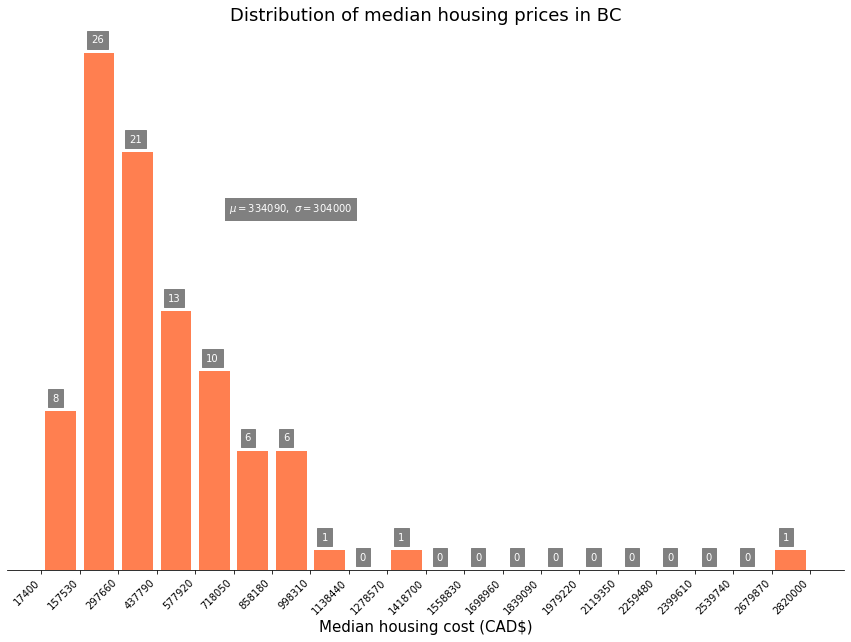

In [106]:
### Plot Histogram of Housing Prices in BC

##The parameter rwidth specifies the width of your bar relative to the width of your bin. 
##For example, if your bin width is say 1 and rwidth=0.5, the bar width will be 0.5. 
##On both side of the bar you will have a space of 0.25.
## BINS MUST MATCH THE BIN VALUE YOU SET FOR NP.HISTOGRAM

ax= Price.plot(kind='hist', 
               figsize=(15, 10), 
               bins=20, 
               rwidth=0.8, 
               histtype='bar',
               color='coral',
               xticks=bin_edges,
               legend=None)

#removing top,right and left borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#set y axis to be hidden
ax.axes.get_yaxis().set_visible(False)
#ax.axes.get_yaxis().set_ticks([]) #another way to hide y axis

#ax.set_xticks(np.arange(len(x))) #needed to add this so I didn't lose the first label entry in the list
#ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')

plt.xticks(rotation=45, horizontalalignment='right')
plt.text(700000, 18, r'$\mu=334090,\ \sigma=304000$', color='white', backgroundcolor='grey')
plt.text(700000, 18, r'$\mu=334090,\ \sigma=304000$', color='white', backgroundcolor='grey')
for i in range(0,len(count)):
    plt.text((bin_edges[i]+40000),(count[i] +0.5), count[i],color='white', backgroundcolor='grey')
plt.title('Distribution of median housing prices in BC',fontsize=18)    
plt.xlabel('Median housing cost (CAD$)',fontsize=15)
plt.ylabel('Count of houses in this price range', fontsize=15)


Relate back to clusters eventually

## Historgram of Growing Season in BC

In [107]:
#create new data frame with only housing price in one column
Grow_season=pd.DataFrame(full_dataset['Growing_Days'])

In [108]:
#Setup for histogram
count, bin_edges = np.histogram(Grow_season, bins=15)

In [109]:
count

array([12,  8,  2,  1, 12,  4,  2, 12,  7,  8, 11,  4,  1,  3,  6])

Text(0, 0.5, 'Count of houses in this price range')

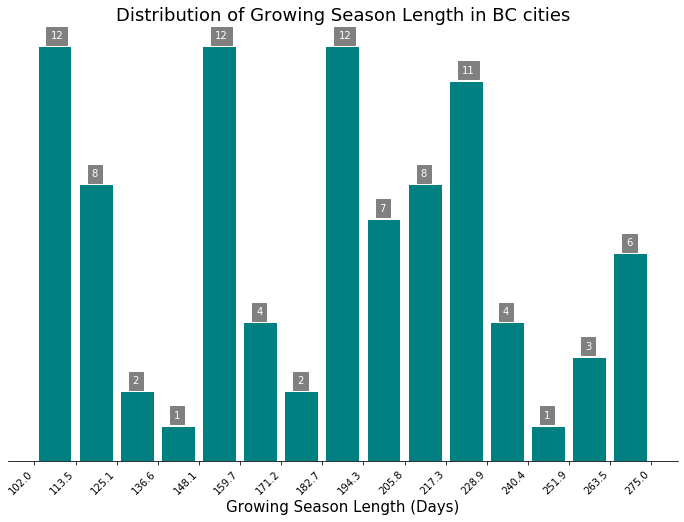

In [110]:
### Plot Histogram of Housing Prices in BC

##The parameter rwidth specifies the width of your bar relative to the width of your bin. 
##For example, if your bin width is say 1 and rwidth=0.5, the bar width will be 0.5. 
##On both side of the bar you will have a space of 0.25.
## BINS MUST MATCH THE BIN VALUE YOU SET FOR NP.HISTOGRAM

ax= Grow_season.plot(kind='hist', 
               figsize=(12, 8), 
               bins=15, 
               rwidth=0.8, 
               histtype='bar',
               color='teal',
               xticks=bin_edges,
               legend=None)

#removing top,right and left borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#set y axis to be hidden
ax.axes.get_yaxis().set_visible(False)
#ax.axes.get_yaxis().set_ticks([]) #another way to hide y axis

#ax.set_xticks(np.arange(len(x))) #needed to add this so I didn't lose the first label entry in the list
#ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')

plt.xticks(rotation=45, horizontalalignment='right')
#plt.text(700000, 18, r'$\mu=334090,\ \sigma=304000$', color='white', backgroundcolor='grey')
#plt.text(700000, 18, r'$\mu=334090,\ \sigma=304000$', color='white', backgroundcolor='grey')
for i in range(0,len(count)):
    plt.text((bin_edges[i]+4.5),(count[i] +0.25), count[i],color='white', backgroundcolor='grey')
plt.title('Distribution of Growing Season Length in BC cities',fontsize=18)    
plt.xlabel('Growing Season Length (Days)',fontsize=15)
plt.ylabel('Count of houses in this price range', fontsize=15)

In [111]:
full_dataset.describe().astype(int)

,Median_House_Price,Latitude,Longitude,2019_pop,Growing_Days,Brewery,Farm,Farmers Market,Trail
count,93,93,93,93,93,93,93,93,93
mean,460812,50,-122,43571,182,3,4,2,7
std,358380,1,3,100216,49,3,5,3,7
min,17400,48,-132,325,102,0,0,0,0
25%,234000,49,-123,4475,153,1,0,0,2
50%,373000,49,-122,11876,193,2,2,1,5
75%,594000,50,-119,35818,224,6,6,6,13
max,2820000,56,-115,685885,275,18,27,10,34


## Descriptive Statistics

In [112]:
FD=full_dataset[['Median_House_Price','2019_pop','Growing_Days','Brewery','Farm','Farmers Market','Trail']]

In [113]:
FD.describe().astype(int)

,Median_House_Price,2019_pop,Growing_Days,Brewery,Farm,Farmers Market,Trail
count,93,93,93,93,93,93,93
mean,460812,43571,182,3,4,2,7
std,358380,100216,49,3,5,3,7
min,17400,325,102,0,0,0,0
25%,234000,4475,153,1,0,0,2
50%,373000,11876,193,2,2,1,5
75%,594000,35818,224,6,6,6,13
max,2820000,685885,275,18,27,10,34


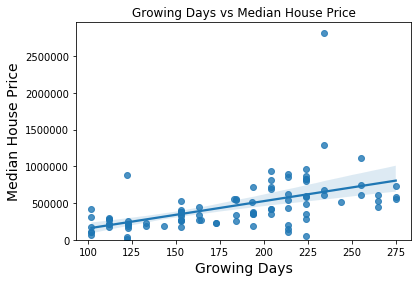

In [114]:
#Playing with sns and correlation plots
import seaborn as sns
sns.regplot(x=full_dataset['Growing_Days'],y=full_dataset['Median_House_Price'],data=full_dataset)
plt.ylim(0,)
plt.xlabel('Growing Days', fontsize=14)
plt.ylabel('Median House Price', fontsize=14)
plt.title("Growing Days vs Median House Price")
data = full_dataset[['Growing_Days','Median_House_Price']]
correlation = data.corr(method='pearson')
#correlation

Instead of doing individual correlation plots, I'd like to look at everything at once to see if there is anything interesting going on.

In [115]:
from scipy import stats
corr_df=FD.corr()

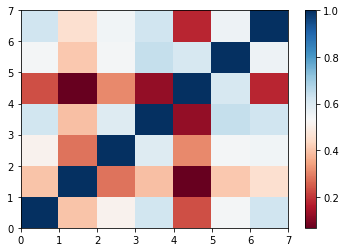

In [116]:
#use the grouped results
#Basic Correlation chart mapped with a colour map - I wanted something a little more informative that would 
#immediately show strength of correlation by size of square.
plt.pcolor(corr_df, cmap='RdBu')
plt.colorbar()
plt.show()

In [117]:
corr_df

,Median_House_Price,2019_pop,Growing_Days,Brewery,Farm,Farmers Market,Trail
Median_House_Price,1.000000,0.400770,0.511558,0.620911,0.232977,0.540566,0.626334
2019_pop,0.400770,1.000000,0.280233,0.394224,0.066531,0.406214,0.459287
Growing_Days,0.511558,0.280233,1.000000,0.593703,0.308419,0.540678,0.549901
Brewery,0.620911,0.394224,0.593703,1.000000,0.123873,0.643460,0.626778
Farm,0.232977,0.066531,0.308419,0.123873,1.000000,0.613473,0.177347
Farmers Market,0.540566,0.406214,0.540678,0.643460,0.613473,1.000000,0.558547
Trail,0.626334,0.459287,0.549901,0.626778,0.177347,0.558547,1.000000


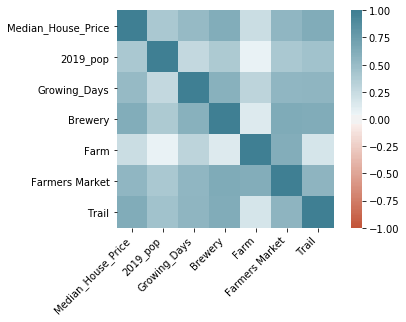

In [118]:
corr = corr_df
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

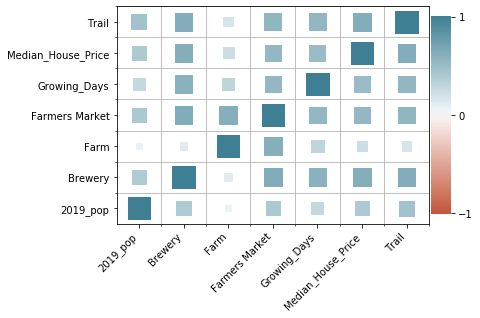

In [119]:
# Step 1 - Make a scatter plot with square markers, set column names as labels
corr = corr_df
def heatmap(x, y, size,color):
    fig, ax = plt.subplots()
    
    ##**Add Colour to plot**###
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]
    ##**Add Colour to plot**###
    
    ##**Setting up for adding colour bar legend**##
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    ##**Setting up for adding colour bar legend**##
    
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s', # Use square as scatterplot marker
    )
 
    # Show column labels on the axes
    ax.set_xticks(np.arange(len(x))) #needed to add this so I didn't lose the first label entry in the list
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks(np.arange(len(y))) #needed to add this so I didn't lose the first label entry in the list
    ax.set_yticklabels(y_labels)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True) # Add grid
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True) # Add grid
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) #set data squares in middle of each grid column
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5]) #set data squares in middle of each grid column
##
    ####***Now add the colour legend***###
        ##**Setting up for adding colour bar legend**##
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 gridax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
        ##**Setting up for adding colour bar legend**##
    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right 
    plt.box(on=None) #remove box around colour bar
    ####***Now add the colour legend***###

corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color = corr['value']
)


###

There are a couple of points of interest here.
1. The highest correlation with median housing price looks to be the number of breweries
2. I thought growing season would be more strongly correlated with median house price because it might indicate good weather. This does not seem to be the case. This is good news for our business venture.

In [120]:
correlation=corr_df.index.sort_values()

In [121]:
corr_df[correlation]

,2019_pop,Brewery,Farm,Farmers Market,Growing_Days,Median_House_Price,Trail
Median_House_Price,0.400770,0.620911,0.232977,0.540566,0.511558,1.000000,0.626334
2019_pop,1.000000,0.394224,0.066531,0.406214,0.280233,0.400770,0.459287
Growing_Days,0.280233,0.593703,0.308419,0.540678,1.000000,0.511558,0.549901
Brewery,0.394224,1.000000,0.123873,0.643460,0.593703,0.620911,0.626778
Farm,0.066531,0.123873,1.000000,0.613473,0.308419,0.232977,0.177347
Farmers Market,0.406214,0.643460,0.613473,1.000000,0.540678,0.540566,0.558547
Trail,0.459287,0.626778,0.177347,0.558547,0.549901,0.626334,1.000000


### 5 highest growing cities last year were

In [122]:
full_dataset[['Location','Median_House_Price','2019_pop','18_19_popchanges','Growing_Days','Brewery','Farmers Market','Farm','Trail']].sort_values('18_19_popchanges',ascending=False).head()

,Location,Median_House_Price,2019_pop,18_19_popchanges,Growing_Days,Brewery,Farmers Market,Farm,Trail
36,Langford,525000.0,42653.0,0.0516804,265,10,4,1,15
15,Cumberland,352000.0,4475.0,0.0499765,194,6,4,7,6
35,Lake Cowichan,250000.0,3594.0,0.043554,184,0,0,0,1
28,Invermere,303000.0,3713.0,0.038311,112,2,0,1,2
17,Duncan,277000.0,5342.0,0.037483,224,3,4,10,4


## Merged Dataset Mapped: Housing, Growing Season, Pop. Size, FS Data

In [123]:
address = 'British Columbia'

geolocator = Nominatim(user_agent="bc_explorer")
location = geolocator.geocode(address)
lati_B = location.latitude
longi_B = location.longitude
print('The geograpical coordinate of British Columbia are {}, {}.'.format(lati_B, longi_B))

The geograpical coordinate of British Columbia are 55.001251, -125.002441.


In [124]:
###******************Output Map of BC with the Cities we will investigate******************###
### Data Labels=City Name, Median House Price, 2019 Population Size, Growing Season (Days) ###
###****************************************************************************************###


# create map of BC using latitude and longitude values
map_BC = folium.Map(location=[lati_B, longi_B], zoom_start=6)

# add markers to map
for lat, lng, loc, price, pop, gro in zip(full_dataset['Latitude'], full_dataset['Longitude'], full_dataset['Location'],full_dataset['Median_House_Price'],full_dataset['2019_pop'],full_dataset['Growing_Days']):
    label = '{},{},{},{}'.format(loc,price,pop,gro)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_BC)  
    
map_BC

# Clustering Potential Cities

This problem requires unsupervised machine learning because there are no labels in the dataset. Instead it is desired to summarize key aspects of clusters for the dataset and perform some additional descriptive analysis on clusters that represent desirable traits.

K means will be used to perform the cluster analysis.

Three parameters will be used to perform the KMeans clustering: 

 - init: Initialization method of the centroids. Value will be: "k-means++" [k-means++: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence]
 - n_clusters: The number of clusters to form as well as the number of centroids to generate.  We will plot kmeans inertia versus number of centroids to choose the best K value (elbow in graph)
 - n_init: Number of time the k-means algorithm will be run with different centroid seeds. 
     The final results will be the best output of n_init consecutive runs in terms of inertia. Value will be: 10

#### Pre-Processing

 __Location__ in this dataset is a categorical variable. k-means algorithm isn't directly applicable to categorical variables because Euclidean distance function isn't really meaningful for discrete variables. This variable is critical for analysis so it will be changed to an integer ID to be referred back to after cluster analysis is done.

In [125]:
copycopy=full_dataset.copy()
data_km=full_dataset.copy()

In [126]:
loc_key=pd.DataFrame({"loc_id": range(1,94),"Location":data_km["Location"]}) # Create Location key matrix which has location name and number assigned to it.

In [127]:
#reformatting in order to perform k means cluster analysis
data_km["loc_id"]=loc_key["loc_id"]
data_km.drop(columns=['Location','Prov_Ter','Latitude','Longitude','Last_date','First_date','18_19_popchanges'],inplace=True)

## K MEANS CLUSTERING METHOD

In [128]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

### Choosing the right cluster number, k

In [129]:
data_scaled=scale(data_km)

Text(0, 0.5, 'Inertia')

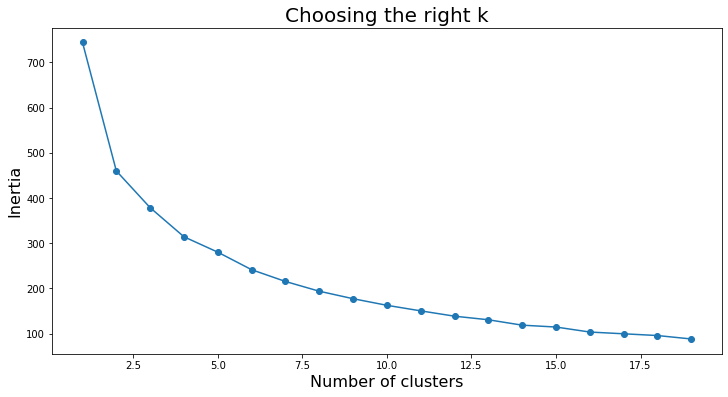

In [130]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.title('Choosing the right k',fontsize=20)
plt.xlabel('Number of clusters',fontsize=16)
plt.ylabel('Inertia', fontsize=16)

Therefore, k = 7 seems to be the best for this dataset

#### Perform Kmeans clustering of data:
 - Normalize data utilizing the sklearn "scale" function, 
 - define number of clusters,
 - and perform kmeans fitting,
 - define cluster labels

#### Normalizing dataset
Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use scale() to normalize our dataset.

In [131]:
X=scale(data_km) #normalizing data_km database

In [132]:
X=scale(data_km)
clusterNum=7
clustering=KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 10)
clustering.fit(X)
labels = clustering.labels_
labels

array([3, 5, 0, 5, 6, 5, 3, 3, 5, 0, 6, 0, 3, 5, 5, 6, 3, 6, 5, 0, 5, 5,
       6, 5, 5, 5, 6, 5, 5, 6, 0, 5, 5, 6, 6, 5, 0, 6, 5, 3, 6, 5, 0, 3,
       0, 1, 5, 0, 6, 3, 0, 1, 1, 6, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       6, 1, 1, 1, 0, 1, 0, 1, 1, 3, 1, 6, 0, 0, 2, 1, 1, 1, 2, 1, 0, 0,
       0, 4, 0, 3, 1], dtype=int32)

### Examine Clusters

In [133]:
#We assign the labels to each row in dataframe.
data_km["Clus_km"] = labels
data_km.head(5)

,Median_House_Price,2019_pop,Growing_Days,Brewery,Farm,Farmers Market,Trail,loc_id,Clus_km
0,620000.0,158457.0,214,5,20,10,7,1,3
1,337000.0,5499.0,163,0,4,1,0,2,5
2,864000.0,253007.0,224,18,1,7,16,3,0
3,166000.0,1052.0,123,0,1,0,0,4,5
4,334000.0,35849.0,184,2,0,0,9,5,6


We can easily check the centroid values by averaging the features in each cluster.

In [134]:
data_km.groupby('Clus_km').mean().astype(int) #find centroid of each cluster

,Median_House_Price,2019_pop,Growing_Days,Brewery,Farm,Farmers Market,Trail,loc_id
Clus_km,,,,,,,,
0,683522,68431,221,8,3,5,16,54
1,260282,11970,151,1,1,0,2,68
2,1061000,635205,229,7,2,6,20,83
3,673100,58834,217,3,18,7,11,34
4,2820000,43945,234,11,1,5,16,90
5,213415,4910,132,0,1,0,1,23
6,392686,18026,206,3,4,2,6,35


In [135]:
#Add location, lat/long information back into the dataset
clusters=pd.merge(data_km,loc_key,on='loc_id')
Clusters=pd.merge(clusters,full_dataset[['Location',"Latitude","Longitude"]],on='Location')

In [136]:
#Define separate dataframes for each cluster
Cluster_1=data_km[data_km['Clus_km']==0]
Cluster_2=data_km[data_km['Clus_km']==1]
Cluster_3=data_km[data_km['Clus_km']==2]
Cluster_4=data_km[data_km['Clus_km']==3]
Cluster_5=data_km[data_km['Clus_km']==4]
Cluster_6=data_km[data_km['Clus_km']==5]
Cluster_7=data_km[data_km['Clus_km']==6]

In [137]:
#list of counts of clusters
print('number of cities in Cluster 0: ', len(Cluster_1.groupby('loc_id').count()))
print('number of cities in Cluster 1: ', len(Cluster_2.groupby('loc_id').count()))
print('number of cities in Cluster 2: ', len(Cluster_3.groupby('loc_id').count()))
print('number of cities in Cluster 3: ', len(Cluster_4.groupby('loc_id').count()))
print('number of cities in Cluster 4: ', len(Cluster_5.groupby('loc_id').count()))
print('number of cities in Cluster 5: ', len(Cluster_6.groupby('loc_id').count()))
print('number of cities in Cluster 6: ', len(Cluster_7.groupby('loc_id').count()))

number of cities in Cluster 0:  22
number of cities in Cluster 1:  23
number of cities in Cluster 2:  2
number of cities in Cluster 3:  10
number of cities in Cluster 4:  1
number of cities in Cluster 5:  20
number of cities in Cluster 6:  15


### Map of clusters

In [138]:
address = 'British Columbia'

geolocator = Nominatim(user_agent="bc_explorer")
location = geolocator.geocode(address)
lati_B = location.latitude
longi_B = location.longitude
print('The geograpical coordinate of British Columbia are {}, {}.'.format(lati_B, longi_B))

The geograpical coordinate of British Columbia are 55.001251, -125.002441.


In [139]:
# create map
map_clusters = folium.Map(location=[lati_B, longi_B], zoom_start=6)

# set color scheme for the clusters
x = np.arange(clusterNum)
#ys = [i + x + (i*x)**2 for i in range(clusterNum)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array=['salmon','indigo','teal','blue','black','maroon','goldenrod']
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi,price, cluster,gro in zip(Clusters['Latitude'], Clusters['Longitude'], Clusters['Location'], Clusters['Median_House_Price'],Clusters['Clus_km'],Clusters['Growing_Days']):
    label = '{},{},{},{}'.format(poi,price,gro,' Cluster ' + str(cluster))
    label = folium.Popup(label, parse_html=True)
    #label = '{},{},{},{}'.format(loc,price,pop,gro)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [140]:
from sklearn.decomposition import PCA

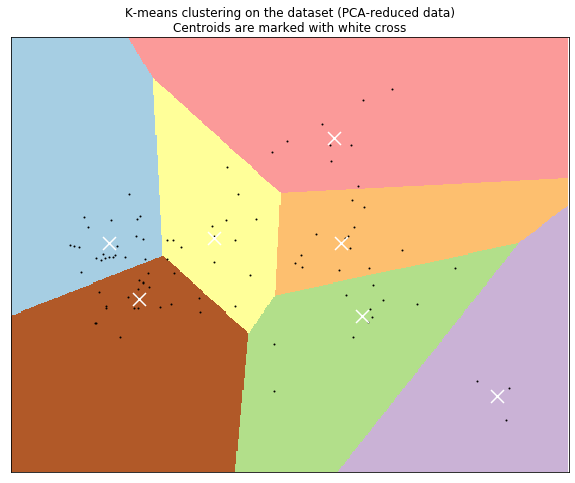

In [141]:
#Reducing Dimensions and plotting clusters
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1,figsize=(10, 8))

plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.title('K-means clustering on the dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

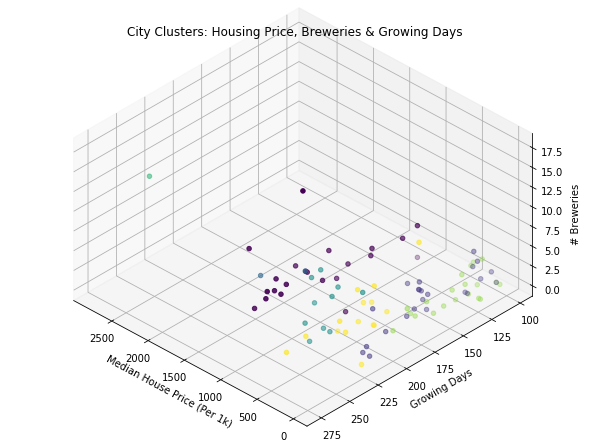

In [142]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[1, 1, 1, 1], elev=48, azim=134,proj_type='ortho')

plt.cla()
ax.set_title('City Clusters: Housing Price, Breweries & Growing Days')
ax.set_xlabel('Median House Price (Per 1k)')
ax.set_ylabel('Growing Days')
ax.set_zlabel('# Breweries')
ax.scatter(data_km['Median_House_Price']/1000, data_km["Growing_Days"],data_km['Brewery'], c= labels.astype(np.float))

## Refining City list further

### Slicing dataset based on cluster 0 and 6

In [153]:
C0=data_km[data_km['Clus_km']==0]
C3=data_km[data_km['Clus_km']==3]
C6=data_km[data_km['Clus_km']==6]
slice_1=pd.merge(C0,loc_key,on='loc_id')
slice_2=pd.merge(C3,loc_key,on='loc_id')
slice_3=pd.merge(C6,loc_key,on='loc_id')
slices=pd.concat([slice_1,slice_2,slice_3], ignore_index=True)
data_slice=pd.merge(slices,full_dataset[['Location',"Latitude","Longitude",'18_19_popchanges']],on='Location')

In [154]:
data_slice.sort_values('Median_House_Price',inplace=True)

In [155]:
data_slice.reset_index(inplace=True)
data_slice.drop(columns=['index'],inplace=True)

In [156]:
d1=data_slice[data_slice['Growing_Days']>210] #exclude cities with growing season below 210

In [158]:
d1

,Median_House_Price,2019_pop,Growing_Days,Brewery,Farm,Farmers Market,Trail,loc_id,Clus_km,Location,Latitude,Longitude,18_19_popchanges
0,58300.0,766.0,224,0,0,0,5,41,6,Masset,54.012447,-132.145224,-0.0388959
1,277000.0,5342.0,224,3,10,4,4,18,6,Duncan,48.778687,-123.708045,0.037483
6,358000.0,32120.0,224,4,8,5,5,49,6,North Cowichan,48.824730,-123.719181,0.010635
12,433500.0,99856.0,214,4,7,2,22,45,0,Nanaimo,49.163759,-123.937972,0.0185958
14,449000.0,14657.0,265,3,2,0,8,78,6,Sooke,48.382572,-123.731518,0.024965
15,493000.0,94534.0,224,2,18,7,13,8,3,Chilliwack,49.157677,-121.951431,0.0259043
16,511000.0,4942.0,244,3,3,0,6,23,6,Gibsons,49.400620,-123.508919,0.00590271
18,525000.0,42653.0,265,10,1,4,15,37,0,Langford,48.449769,-123.504666,0.0516804
20,542000.0,3790.0,214,1,2,1,11,38,6,Lantzville,49.250711,-124.074654,-0.00394218
22,558000.0,18867.0,275,11,2,2,11,10,0,Colwood,48.423414,-123.493965,0.0298019


In [159]:
d2=d1[d1['Median_House_Price']<700000] #exclude cities with median house price above 700 000

In [160]:
d3=d2[d2['Trail']>3] #exclude cities with less than 3 trails close by

In [161]:
d3

,Median_House_Price,2019_pop,Growing_Days,Brewery,Farm,Farmers Market,Trail,loc_id,Clus_km,Location,Latitude,Longitude,18_19_popchanges
0,58300.0,766.0,224,0,0,0,5,41,6,Masset,54.012447,-132.145224,-0.0388959
1,277000.0,5342.0,224,3,10,4,4,18,6,Duncan,48.778687,-123.708045,0.037483
6,358000.0,32120.0,224,4,8,5,5,49,6,North Cowichan,48.824730,-123.719181,0.010635
12,433500.0,99856.0,214,4,7,2,22,45,0,Nanaimo,49.163759,-123.937972,0.0185958
14,449000.0,14657.0,265,3,2,0,8,78,6,Sooke,48.382572,-123.731518,0.024965
15,493000.0,94534.0,224,2,18,7,13,8,3,Chilliwack,49.157677,-121.951431,0.0259043
16,511000.0,4942.0,244,3,3,0,6,23,6,Gibsons,49.400620,-123.508919,0.00590271
18,525000.0,42653.0,265,10,1,4,15,37,0,Langford,48.449769,-123.504666,0.0516804
20,542000.0,3790.0,214,1,2,1,11,38,6,Lantzville,49.250711,-124.074654,-0.00394218
22,558000.0,18867.0,275,11,2,2,11,10,0,Colwood,48.423414,-123.493965,0.0298019


In [162]:
d5=d3.sort_values('18_19_popchanges', ascending=False).head()

In [163]:
d5.drop(columns=['2019_pop','loc_id','Clus_km','Latitude','Longitude'],inplace=True)

# Conclusions

## Final Top 5 City List

In [164]:
d5.set_index('Location')

,Median_House_Price,Growing_Days,Brewery,Farm,Farmers Market,Trail,18_19_popchanges
Location,,,,,,,
Langford,525000.0,265,10,1,4,15,0.0516804
Duncan,277000.0,224,3,10,4,4,0.037483
Colwood,558000.0,275,11,2,2,11,0.0298019
Chilliwack,493000.0,224,2,18,7,13,0.0259043
View Royal,614000.0,265,10,0,4,17,0.0251706
